<h2>Tested in Notebook to find the error</h2>

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.nn import init
import numpy as np
from torchvision.transforms import ToPILImage
import cv2
import os
from PIL import Image
from sync_batchnorm import SynchronizedBatchNorm2d

In [16]:
# norm_nc: the #channels of the normalized activations, hence the output dim of SPADE
# label_nc: the #channels of the input semantic map, hence the input dim of SPADE
# label_nc: also equivalent to the # of input label classes
class SPADE(nn.Module):
  def __init__(self, opt, norm_nc):
    super().__init__()

    self.param_free_norm = SynchronizedBatchNorm2d(norm_nc, affine=False)

    # number of internal filters for generating scale/bias
    nhidden = 128
    # size of kernels
    kernal_size = 3
    # padding size
    padding = kernal_size // 2

    self.mlp_shared = nn.Sequential(
      nn.Conv2d(opt['label_nc'], nhidden, kernel_size=kernal_size, padding=padding),
      nn.ReLU()
    )
    self.mlp_gamma = nn.Conv2d(nhidden, norm_nc, kernel_size=kernal_size, padding=padding)
    self.mlp_beta = nn.Conv2d(nhidden, norm_nc, kernel_size=kernal_size, padding=padding)

  def forward(self, x, segmap):
    # Part 1. generate parameter-free normalized activations
    normalized = self.param_free_norm(x)

    # Part 2. produce scaling and bias conditioned on semantic map
    # resize input segmentation map to match x.size() using nearest interpolation
    # N, C, H, W = x.size()
    segmap = F.interpolate(segmap, size=x.size()[2:], mode='nearest')
    actv = self.mlp_shared(segmap)
    gamma = self.mlp_gamma(actv)
    beta = self.mlp_beta(actv)

    # apply scale and bias
    out = normalized * (1 + gamma) + beta

    return out

In [17]:
class SPADEGenerator(nn.Module):
  def __init__(self, opt):
    super().__init__()

    # nf: # of gen filters in first conv layer
    nf = 64

    self.sw, self.sh = self.compute_latent_vector_size(opt['crop_size'], opt['aspect_ratio'])

    self.fc = nn.Conv2d(opt['label_nc'], 16 * nf, 3, padding=1)

    self.head_0 = SPADEResnetBlock(opt, 16 * nf, 16 * nf)

    self.G_middle_0 = SPADEResnetBlock(opt, 16 * nf, 16 * nf)
    self.G_middle_1 = SPADEResnetBlock(opt, 16 * nf, 16 * nf)

    self.up_0 = SPADEResnetBlock(opt, 16 * nf, 8 * nf)
    self.up_1 = SPADEResnetBlock(opt, 8 * nf, 4 * nf)
    self.up_2 = SPADEResnetBlock(opt, 4 * nf, 2 * nf)
    self.up_3 = SPADEResnetBlock(opt, 2 * nf, 1 * nf)

    self.conv_img = nn.Conv2d(1 * nf, 3, 3, padding=1)

    self.up = nn.Upsample(scale_factor=2)
  
  def compute_latent_vector_size(self, crop_size, aspect_ratio):
    num_up_layers = 5

    sw = crop_size // (2**num_up_layers)
    sh = round(sw / aspect_ratio)

    return sw, sh
  
  def forward(self, seg):
    # we downsample segmap and run convolution
    x = F.interpolate(seg, size=(self.sh, self.sw))
    x = self.fc(x)

    x = self.head_0(x, seg)

    x = self.up(x)
    x = self.G_middle_0(x, seg)
    x = self.G_middle_1(x, seg)

    x = self.up(x)
    x = self.up_0(x, seg)
    x = self.up(x)
    x = self.up_1(x, seg)
    x = self.up(x)
    x = self.up_2(x, seg)
    x = self.up(x)
    x = self.up_3(x, seg)

    x = self.conv_img(F.leaky_relu(x, 2e-1))
    x = torch.tanh(x)

    return x

import torch.nn.utils.spectral_norm as spectral_norm

# label_nc: the #channels of the input semantic map, hence the input dim of SPADE
# label_nc: also equivalent to the # of input label classes
class SPADEResnetBlock(nn.Module):
  def __init__(self, opt, fin, fout):
    super().__init__()

    self.learned_shortcut = (fin != fout)
    fmiddle = min(fin, fout)

    self.conv_0 = spectral_norm(nn.Conv2d(fin, fmiddle, kernel_size=3, padding=1))
    self.conv_1 = spectral_norm(nn.Conv2d(fmiddle, fout, kernel_size=3, padding=1))
    if self.learned_shortcut:
      self.conv_s = spectral_norm(nn.Conv2d(fin, fout, kernel_size=1, bias=False))

    # define normalization layers
    self.norm_0 = SPADE(opt, fin)
    self.norm_1 = SPADE(opt, fmiddle)
    if self.learned_shortcut:
      self.norm_s = SPADE(opt, fin)

  # note the resnet block with SPADE also takes in |seg|,
  # the semantic segmentation map as input
  def forward(self, x, seg):
    x_s = self.shortcut(x, seg)

    dx = self.conv_0(self.relu(self.norm_0(x, seg)))
    dx = self.conv_1(self.relu(self.norm_1(dx, seg)))

    out = x_s + dx
    return out

  def shortcut(self, x, seg):
    if self.learned_shortcut:
      x_s = self.conv_s(self.norm_s(x, seg))
    else:
      x_s = x
    return x_s

  def relu(self, x):
    return F.leaky_relu(x, 2e-1)

In [18]:
class Pix2PixModel(torch.nn.Module):
  def __init__(self, opt):
    super().__init__()
    self.opt = opt
    self.FloatTensor = torch.cuda.FloatTensor if opt['use_gpu'] \
      else torch.FloatTensor

    self.netG = self.initialize_networks(opt)
  
  def forward(self, data, mode):
    input_semantics, real_image = self.preprocess_input(data)

    if mode == 'inference':
      with torch.no_grad():
        fake_image = self.generate_fake(input_semantics)
      return fake_image
    else:
      raise ValueError("|mode| is invalid")
  
  def preprocess_input(self, data):
    data['label'] = data['label'].long()

    # move to GPU and change data types
    if self.opt['use_gpu']:
      data['label'] = data['label'].cuda()
      data['instance'] = data['instance'].cuda()
      data['image'] = data['image'].cuda()

    # create one-hot label map
    label_map = data['label']
    bs, _, h, w = label_map.size()
    input_label = self.FloatTensor(bs, self.opt['label_nc'], h, w).zero_()
    # one whole label map -> to one label map per class
    input_semantics = input_label.scatter_(1, label_map, 1.0)                     #error on this line

    return input_semantics, data['image']
  
  def generate_fake(self, input_semantics):
    fake_image = self.netG(input_semantics)
    return fake_image
  
  def create_network(self, cls, opt):
    net = cls(opt)
    if self.opt['use_gpu']:
      net.cuda()

    gain=0.02
    def init_weights(m):
      classname = m.__class__.__name__
      if classname.find('BatchNorm2d') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
          init.normal_(m.weight.data, 1.0, gain)
        if hasattr(m, 'bias') and m.bias is not None:
          init.constant_(m.bias.data, 0.0)
      elif hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.xavier_normal_(m.weight.data, gain=gain)
        if hasattr(m, 'bias') and m.bias is not None:
          init.constant_(m.bias.data, 0.0)
    # Applies fn recursively to every submodule (as returned by .children()) as well as self
    net.apply(init_weights)
    
    return net
  
  def load_network(self, net, label, epoch, opt):
    save_filename = '%s_net_%s.pth' % (epoch, label)
    save_path = os.path.join(opt['checkpoints_dir'], save_filename)
    weights = torch.load(save_path)
    net.load_state_dict(weights)
    return net

  def initialize_networks(self, opt):
    netG = self.create_network(SPADEGenerator, opt)

    if not opt['isTrain']:
      netG = self.load_network(netG, 'G', opt['which_epoch'], opt)
    
    # self.print_network(netG)

    return netG
  
  def print_network(self, net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print('Network [%s] was created. Total number of parameters: %.1f million. '
          % (type(net).__name__, num_params / 1000000))
    print(net)

In [19]:
def __scale_width(img, target_width, method=Image.BICUBIC):
  ow, oh = img.size
  if (ow == target_width):
    return img
  w = target_width
  h = int(target_width * oh / ow)
  return img.resize((w, h), method)

def get_transform(opt, method=Image.BICUBIC, normalize=True):
  transform_list = []
  transform_list.append(transforms.Lambda(lambda img: __scale_width(img, opt['load_size'], method)))
  transform_list += [transforms.ToTensor()]
  if normalize:
    transform_list += [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
  
  return transforms.Compose(transform_list)

C:\Users\nirva\AppData\Local\Temp\ipykernel_22232\1742670730.py:1: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  def __scale_width(img, target_width, method=Image.BICUBIC):
C:\Users\nirva\AppData\Local\Temp\ipykernel_22232\1742670730.py:9: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  def get_transform(opt, method=Image.BICUBIC, normalize=True):


In [20]:
def evaluate(labelmap):
    opt = {
        'label_nc': 182, # num classes in coco model
        'crop_size': 512,
        'load_size': 512,
        'aspect_ratio': 1.0,
        'isTrain': False,
        'checkpoints_dir': './pretrained',
        'which_epoch': 'latest',
        'use_gpu': False
    }
    model = Pix2PixModel(opt)
    model.eval()

    image = Image.fromarray(np.array(labelmap).astype(np.uint8))

    transform_label = get_transform(opt, method=Image.NEAREST, normalize=False)
    # transforms.ToTensor in transform_label rescales image from [0,255] to [0.0,1.0]
    # lets rescale it back to [0,255] to match our label ids
    label_tensor = transform_label(image) * 255#178.4
    label_tensor[label_tensor == 255] = opt['label_nc'] # 'unknown' is opt.label_nc
    print("label_tensor:", label_tensor.shape)
    
    # not using encoder, so creating a blank image...
    transform_image = get_transform(opt)
    image_tensor = transform_image(Image.new('RGB', (500, 500)))

    data = {
        'label': label_tensor.unsqueeze(0),
        'instance': label_tensor.unsqueeze(0),
        'image': image_tensor.unsqueeze(0)
    }
    print(data['label'])
    generated = model(data, mode='inference')
    print("generated_image:", generated.shape)

    return generated
def to_image(generated):
    to_img = ToPILImage()
    normalized_img = ((generated.reshape([3, 512, 512]) + 1) / 2.0) * 255.0
    return to_img(normalized_img.byte().cpu())


C:\Users\nirva\AppData\Local\Temp\ipykernel_22232\206520631.py:17: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transform_label = get_transform(opt, method=Image.NEAREST, normalize=False)


label_tensor: torch.Size([1, 516, 512])
tensor([[[[156., 156., 156.,  ..., 156., 156., 156.],
          [156., 156., 156.,  ..., 156., 156., 156.],
          [156., 156., 156.,  ..., 156., 156., 156.],
          ...,
          [153., 153., 153.,  ..., 153., 153., 153.],
          [153., 153., 153.,  ..., 153., 153., 153.],
          [153., 153., 153.,  ..., 153., 153., 153.]]]])
generated_image: torch.Size([1, 3, 512, 512])


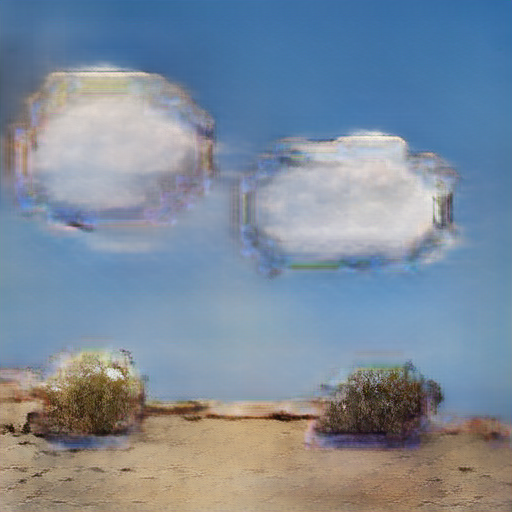

In [21]:
labelmap = cv2.imread('C:/Users/nirva/Desktop/UniStuff/img3.jpg')#used the test image
labelmap = labelmap[:,:,2]
image = evaluate(labelmap)
rimage = to_image(image)
rimage